In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from keras_tuner import GridSearch
from tensorflow import keras

random_state = 42

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.expand_frame_repr', False)  # Don't wrap lines
pd.set_option('display.precision', 4)  # Set decimal precision

<center>
<i>Amortized Loan Formula</i>
</center>

$$A = P\frac{\textit{i}(1 + \textit{i})^\textit{n}}{(1 + \textit{i})^\textit{n} - 1}$$


In [3]:
def calc_payment(principal: float, interest: float, term: int) -> float:
    """
    Calculate the monthly payment for a loan using the formula above:

    Args:
        principal (float): The principal amount of the loan
        interest (float): The monthly interest rate
        term (int): The term of the loan in months

    Returns:
        float: The monthly payment for the loan
    """
    return principal * (interest * (1 + interest) ** term) / ((1 + interest) ** term - 1)

def clean_df(df: pd.DataFrame, drop_na=False) -> pd.DataFrame:
    """
    Clean and preprocess the auto loan application dataframe by removing unnecessary columns
    and standardizing status values.

    Args:
        df (pd.DataFrame): Input dataframe containing raw auto loan application data
        drop_na (bool, optional): Whether to drop rows with NA values. Defaults to False.

    Returns:
        pd.DataFrame: Cleaned dataframe with:
            - Removed columns that are not needed for analysis (e.g. dealer info, payment details)
            - Standardized status values to 'Denial' or 'Approved'
            - Empty strings for null tags
    """
    dfa = df.drop(columns=[
        'id', 
        'app_type',
        'debt_monthly_payment',
        'debt_monthly_payment_w_payment', 
        'dti_monthly',
        'dti_monthly_w_payment',
        'vanatage_score',
        'ltv_wholesale_avg',
        'ltv_retail_avg',
        'ltv_retail_clean',
        'wholesale_clean',
        'wholesale_avg',
        'retail_clean',
        'retail_avg',
        'dealer_cifno', 
        'dealer_company',
        'denial_reasons',
        'dealer_state',
        'denial_other',
        'pending_reasons',
        'pending_reasons',
        'pending_other',
        'is_closed',
        'close_reason',
        'close_note',
        'lender_percent',
        'lender_fee',
        'aq_fee',
        'est_payment',
        'no_credit',
        'decision_back_and_forth',
        'term',
        'apr',
        'pti_monthly',
        'has_cobuyer',
        'decisioned_by',
        'credit_inquiries',
        'credit_ssn_match', 
        'cash_down', 
        'amount_approved',
        'credit_dpd_30_last_12_percent',
        'credit_dpd_60_last_12_percent',
        'credit_dpd_90_last_12_percent',
        'credit_dpd_120_last_12_percent',
        'credit_dpd_30_last_24_percent',
        'credit_dpd_60_last_24_percent',
        'credit_dpd_90_last_24_percent',
        'credit_dpd_120_last_24_percent',
        'tag',
    ])
    dfa['status'] = dfa['status'].apply(lambda x: 'Denial' if x == 'Denial' else 'Approved')
    if drop_na:
        dfa = dfa.dropna(axis=0)
    return dfa

### Drop NA
null/na values are a very small portion of the data so we will drop them.

In [4]:
df = clean_df(pd.read_csv('data/applications.csv'), drop_na=True)

In [9]:
df.describe()

,monthly_income,job_time_months,res_time_months,ltv_wholesale_clean,credit_chargeoffs,credit_child_supports,credit_wage_earners,credit_bankruptcies,credit_repos,credit_foreclosures,credit_collections,credit_line_suspended,credit_past_due,credit_past_due_bankruptcy,credit_past_due_medical,credit_past_due_auto,credit_past_due_mortgage,credit_current_balance,credit_monthly_payment,credit_months_since_repo,credit_months_since_bankruptcy,credit_months_since_foreclosure,credit_months_since_chargeoff,credit_age_months,credit_dpd_30,credit_dpd_60,credit_dpd_90,credit_dpd_120
count,45266.000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0,45266.0000,45266.0000,45266.0000,4.5266e+04,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000,45266.0000
mean,3897.950,40.7921,62.1653,154.2562,2.0877,0.0196,0.0146,-0.7835,0.1542,0.0011,0.7532,0.0077,2314.9076,-1.0,-1.0000,1289.9912,17.5875,1.9511e+04,328.8756,1.9545,2.3619,-0.9610,18.7085,174.4553,0.1420,0.1086,0.0702,0.2241
std,4269.084,55.6832,75.5894,141.6794,3.0119,0.1588,0.2885,1.1725,0.5655,0.0352,0.6760,0.0872,4376.9261,0.0,0.0066,3497.3278,345.0245,4.7919e+04,607.1431,12.7303,15.9758,1.4442,24.2192,122.3935,0.4497,0.3835,0.3313,0.9440
min,0.000,0.0000,0.0000,2.1900,0.0000,0.0000,0.0000,-1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0,-1.0000,-1.0000,-1.0000,0.0000e+00,0.0000,-1.0000,-1.0000,-1.0000,-1.0000,1.0000,0.0000,0.0000,0.0000,0.0000
25%,2600.000,8.0000,24.0000,121.7000,0.0000,0.0000,0.0000,-1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0,-1.0000,-1.0000,-1.0000,6.1925e+02,0.0000,-1.0000,-1.0000,-1.0000,-1.0000,72.0000,0.0000,0.0000,0.0000,0.0000
50%,3221.000,24.0000,36.0000,140.3950,1.0000,0.0000,0.0000,-1.0000,0.0000,0.0000,1.0000,0.0000,253.0000,-1.0,-1.0000,0.0000,-1.0000,5.6590e+03,70.0000,-1.0000,-1.0000,-1.0000,11.0000,154.0000,0.0000,0.0000,0.0000,0.0000
75%,4250.000,48.0000,72.0000,166.4100,3.0000,0.0000,0.0000,-1.0000,0.0000,0.0000,1.0000,0.0000,2570.7500,-1.0,-1.0000,0.0000,-1.0000,1.8083e+04,460.0000,-1.0000,-1.0000,-1.0000,30.0000,255.0000,0.0000,0.0000,0.0000,0.0000
max,480000.000,720.0000,756.0000,10433.6000,42.0000,5.0000,19.0000,36.0000,8.0000,2.0000,2.0000,1.0000,133381.0000,-1.0,0.0000,116351.0000,25708.0000,2.8717e+06,12518.0000,112.0000,140.0000,90.0000,136.0000,910.0000,11.0000,10.0000,14.0000,29.0000


### Remove outliers
Monthly Income has a some very high outliers. We will remove them.

In [5]:
iqr = df['monthly_income'].quantile(0.75) - df['monthly_income'].quantile(0.25)
upper_bound = df['monthly_income'].quantile(0.75) + 1.5 * iqr
df = df[(df['monthly_income'] < upper_bound)]

### Status Distribution
Check the distribution of the statuses. To see if classes are balanced.

In [11]:
df['status'].value_counts()

status
Denial      25476
Approved    16867
Name: count, dtype: int64

### Drop columns
We will drop the status and app_id columns as they are not features.
drop_cols = ['status', 'app_id']

In [6]:
drop_cols = ['status', 'app_id']

In [7]:
x = df.drop(columns=drop_cols)
y = df['status']
y_enc = np.where(y == 'Approved', 1, 0)
x_train, x_test, y_train, y_test = train_test_split(x, y_enc, test_size=0.3, random_state=42, stratify=y_enc)

# Neural Networks

In [ ]:
import multiprocessing

def get_optimal_workers() -> int:
    return multiprocessing.cpu_count() - 4


In [7]:
### Build Function

"""
params:
    layers: list[neurons: int]
""" 
def build_fxn(layers: list[int], activation: str = 'relu') -> Sequential:
    model = Sequential()
    model.add(Input(shape=(x_train.shape[1],)))
    for neurons in layers:
        model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        metrics=['recall'],
    )
    return model

In [8]:
x_train_scaled = StandardScaler().fit_transform(x_train)
x_test_scaled = StandardScaler().fit_transform(x_test)

In [36]:
def model_builder(hp: kt.HyperParameters):
    model = keras.Sequential()

    model.add(keras.layers.Input(shape=(x_train.shape[1],)))
    
    n_layers = hp.Int('n_layers', min_value=1, max_value=5, step=1)
    
    for i in range(n_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=64)

        model.add(keras.layers.Dense(
            units=units,
            activation=hp.Choice(f'activation_{i}', ['relu', 'tanh'])
        ))

        dropout_rate = hp.Choice(f'dropout_rate_{i}', [0.0, 0.2, 0.4])
        model.add(keras.layers.Dropout(dropout_rate))
    

    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.Recall(name='recall'),  # Added name
            tf.keras.metrics.Precision(name='precision'),  # Added name
            tf.keras.metrics.Accuracy(name='accuracy')  # Added name
        ],
    )
    
    return model

tuner = GridSearch(
    model_builder,
    objective='val_recall',
    max_trials=50,
    executions_per_trial=3,
    directory='keras_tuner',
    project_name='nn_decision_classifier',
)

tuner.search(x_train_scaled, y_train,
    epochs=50,
    validation_data=(x_test_scaled, y_test),
    callbacks=[keras.callbacks.EarlyStopping(patience=5)],
    verbose=0,
    batch_size=32,
)

In [37]:
best_model = tuner.get_best_models(num_models=1)[0]

In [38]:
import joblib
joblib.dump(best_model, 'nn_model.pkl')

['nn_model.pkl']

In [9]:
import joblib
best_model = joblib.load('nn_model.pkl')


In [10]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,885 (11.27 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,924 (7.52 KB)

397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step


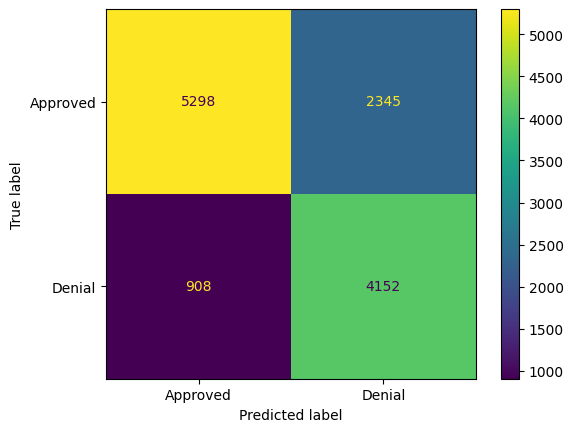

In [11]:
nn_recall_score = recall_score(y_test, np.where(best_model.predict(x_test_scaled) > 0.5, 1, 0))
nn_precision_score = precision_score(y_test, np.where(best_model.predict(x_test_scaled) > 0.5, 1, 0))
nn_accuracy_score = accuracy_score(y_test, np.where(best_model.predict(x_test_scaled) > 0.5, 1, 0))
nn_f1_score = f1_score(y_test, np.where(best_model.predict(x_test_scaled) > 0.5, 1, 0))

ConfusionMatrixDisplay.from_predictions(y_test, np.where(best_model.predict(x_test_scaled) > 0.5, 1, 0), display_labels=['Approved', 'Denial'])


In [12]:
df_nn_results = pd.DataFrame({
    'recall_score': nn_recall_score,
    'precision_score': nn_precision_score,
    'accuracy_score': nn_accuracy_score,
    'f1_score': nn_f1_score,
}, index=['Neural Network'])
df_nn_results

,recall_score,precision_score,accuracy_score,f1_score
Neural Network,0.8206,0.6391,0.7439,0.7185
